# Description

This is the neural network training and testing pipeline implemented with **pure numpy**.

The details of the task and the common things of the neural network architecture are provided in the TorchNN notebooks. The essential of this notebook is the pure-numpy implementation without using any DL frameworks.

## Result metrics

As learning on CPU is quite a slow process so here is provided only the test launch. The result (and the only goal) is showing that the algorithm does work.

# Imports and environment

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import datetime
import pickle
import os
from numba import njit

from sklearn.metrics import accuracy_score

from IPython.display import display as disp
from IPython.display import clear_output

# Loading the dataset

In [2]:
class image_objects():
    """
    Image loading and preprocessing.
    """
    
    def __init__(self, path, filenames,):
        """
        Initialization.
        Loads the metadata from a local disk.
        path : files directory
        filenames : array of the arrays of the two items (jpg and txt) for each image
        """
        self.path = path
        self.filenames = filenames
        self.augmentation_is_done = False
        
        self.meta_raw = []
        for i in np.arange(self.filenames.shape[0]):
            with open(f'{self.path}{self.filenames[i, 1]}', 'r') as f:
                string = f.read()
            self.meta_raw.append(np.array(string.split(' '), dtype='int'))
        
        self.meta_raw = np.array(self.meta_raw)
    
    
    def split_indices(self, valid_frac, test_frac,):
        """
        Splits the indices to the train, validation and test samples.
        """
        index = np.arange(self.meta_raw.shape[0])
        labels = self.meta_raw[:, 0].copy()
        classes = np.unique(self.meta_raw[:, 0])

        index_by_class = []

        for i in np.arange(classes.shape[0]):
            index_by_class.append(index[labels == classes[i]])
            np.random.shuffle(index_by_class[i])

            bounds = np.array(
                [
                    index_by_class[i].shape[0] * (1 - (valid_frac + test_frac)),
                    index_by_class[i].shape[0] * (1 - test_frac),
                ],
                dtype = 'int'
            )

            index_by_class[i] = [
                index_by_class[i][:bounds[0]],
                index_by_class[i][bounds[0]:bounds[1]],
                index_by_class[i][bounds[1]:],
            ]

        self.index_tr_basic = np.array([], dtype='int')
        self.index_va = np.array([], dtype='int')
        self.index_te = np.array([], dtype='int')

        for i in np.arange(classes.shape[0]):
            self.index_tr_basic = np.append(self.index_tr_basic, index_by_class[i][0])
            self.index_va = np.append(self.index_va, index_by_class[i][1])
            self.index_te = np.append(self.index_te, index_by_class[i][2])

        np.random.shuffle(self.index_tr_basic)
        np.random.shuffle(self.index_va)
        np.random.shuffle(self.index_te)

        print(self.index_tr_basic.shape)
        print(self.index_va.shape)
        print(self.index_te.shape)


    def transform(self, size=256,):
        """
        Transforms the images from raw to input-ready format.
        size : size of the final square image
        """
        self.size = size
        self.meta_bw = self.meta_raw.copy()
        self.meta_padded = self.meta_raw.copy()
        self.meta_resized = self.meta_padded.copy()
        self.pads = np.zeros((self.filenames.shape[0], 4), dtype='int')
        self.size_raw = []
        self.imgs = []
        
        for i in np.arange(self.filenames.shape[0]):
            img = np.array(Image.open(f'{self.path}{self.filenames[i, 0]}'))
            if img.ndim == 2:
                img = np.expand_dims(img, 2)
            self.size_raw.append(img.shape[:2])
        
            # Black and white
            img = np.mean(img, axis=2, dtype='int')
            
            # Padding
            self.pads[i, 0] = (np.max(img.shape[:2]) - img.shape[0]) // 2                     # top
            self.pads[i, 1] = (np.max(img.shape[:2]) - img.shape[0]) // 2 + img.shape[0] % 2  # bottom
            self.pads[i, 2] = (np.max(img.shape[:2]) - img.shape[1]) // 2                     # left
            self.pads[i, 3] = (np.max(img.shape[:2]) - img.shape[1]) // 2 + img.shape[1] % 2  # right
            
            img = cv2.copyMakeBorder(img, *self.pads[i], cv2.BORDER_REPLICATE)
            self.meta_padded[i, 1] += self.pads[i, 2]
            self.meta_padded[i, 2] += self.pads[i, 0]
            self.meta_padded[i, 3] += self.pads[i, 3]
            self.meta_padded[i, 4] += self.pads[i, 1]
            
            # Resizing
            img = cv2.resize(img.astype('float64'), (self.size, self.size), interpolation=cv2.INTER_CUBIC)
            self.meta_resized[i] = self.meta_padded[i]
            self.meta_resized[i, 1:5] = np.round(self.meta_resized[i, 1:5] * (self.size / np.max(self.size_raw[i])), 0).astype('int')
            
            self.imgs.append(np.array(img, dtype='uint8'))
        
        self.imgs = np.array(self.imgs, dtype='uint8')
        self.size_raw = np.array(self.size_raw)
        
        self.print_imgs_array_details()
    
    
    def show(self, i=None, mode='resized', roi=True,):
        """
        Displays the image.
        mode : "raw", "bw", "padded", "resized"
        roi : bool
        """
        # Choosing the item
        i = i if i != None else np.random.randint(0, self.filenames.shape[0])
        print(i)

        # Loading the raw image if necessary
        if mode != 'mask':
            img_raw = np.array(Image.open(f'{self.path}{self.filenames[i, 0]}'))
        
        # Computing the image
        if mode == 'raw':
            img = img_raw
            ax_img = plt.imshow(img)
            meta = self.meta_raw[i]
        elif mode == 'bw':
            img = np.mean(img_raw, axis=2, dtype='int')
            ax_img = plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            meta = self.meta_bw[i]
        elif mode == 'padded':
            img = cv2.copyMakeBorder(np.mean(img_raw, axis=2, dtype='int'), *self.pads[i], cv2.BORDER_REPLICATE)
            ax_img = plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            meta = self.meta_padded[i]
        if mode == 'resized':
            img = cv2.resize(
                cv2.copyMakeBorder(np.mean(img_raw, axis=2, dtype='int'), *self.pads[i], cv2.BORDER_REPLICATE).astype('float64'), 
                (self.size, self.size),
                interpolation=cv2.INTER_CUBIC
            )
            ax_img = plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            try:
                meta = self.meta_resized[i]
            except:
                meta = self.meta_augment[i]
        if mode == 'mask':
            img = self.imgs[i, 1]
            ax_img = plt.imshow(img, cmap='gray', vmin=0, vmax=255)
            try:
                meta = self.meta_resized[i]
            except:
                meta = self.meta_augment[i]
        
        # Plotting the image
        disp(meta)
        ax = []
        ax.append(ax_img)
        if roi:
            ax.append(plt.vlines((meta[1], meta[3],), meta[2], meta[4], colors='red'))
            ax.append(plt.hlines((meta[2], meta[4],), meta[1], meta[3], colors='red'))
        plt.show(ax)
    
    
    def augmentation(self,):
        """
        Implementation of the augmentation.
        """
        if self.augmentation_is_done is not True:
            self.imgs = np.append(self.imgs, np.flip(self.imgs[self.index_tr_basic], axis=2), axis=0)
            self.imgs = np.append(self.imgs, np.transpose(self.imgs[self.index_tr_basic], axes=(0, 2, 1)), axis=0)
            self.imgs = np.append(self.imgs, np.flip(np.transpose(self.imgs[self.index_tr_basic], axes=(0, 2, 1)), axis=2), axis=0)
            self.imgs = np.append(self.imgs, np.flip(self.imgs[self.index_tr_basic], axis=1), axis=0)

            meta_1 = self.meta_resized[self.index_tr_basic].copy()
            meta_2 = self.meta_resized[self.index_tr_basic].copy()
            meta_3 = self.meta_resized[self.index_tr_basic].copy()
            meta_4 = self.meta_resized[self.index_tr_basic].copy()

            meta_1[:, 1] = self.size - self.meta_resized[self.index_tr_basic][:, 3]
            meta_1[:, 3] = self.size - self.meta_resized[self.index_tr_basic][:, 1]

            meta_2[:, 1] = meta_1[:, 2]
            meta_2[:, 2] = self.size - meta_1[:, 3]
            meta_2[:, 3] = meta_1[:, 4]
            meta_2[:, 4] = self.size - meta_1[:, 1]

            meta_3[:, 1] = self.size - meta_2[:, 3]
            meta_3[:, 2] = meta_2[:, 2]
            meta_3[:, 3] = self.size - meta_2[:, 1]
            meta_3[:, 4] = meta_2[:, 4]

            meta_4[:, 2] = self.size - self.meta_resized[self.index_tr_basic][:, 4]
            meta_4[:, 4] = self.size - self.meta_resized[self.index_tr_basic][:, 2]

            self.meta_augment = self.meta_resized.copy()
            self.meta_augment = np.append(self.meta_augment, meta_1, axis=0)
            self.meta_augment = np.append(self.meta_augment, meta_2, axis=0)
            self.meta_augment = np.append(self.meta_augment, meta_3, axis=0)
            self.meta_augment = np.append(self.meta_augment, meta_4, axis=0)
        
        self.index_tr = self.index_tr_basic.copy()
        self.index_tr = np.append(self.index_tr, np.arange(self.filenames.shape[0], self.imgs.shape[0]))
        
        self.meta_ready = self.meta_augment.copy().astype('float64')
        self.meta_ready[:, 0][self.meta_ready[:, 0] == 2] = 0
        self.meta_ready[:, 1:] = self.meta_ready[:, 1:] * 1. / self.size
        
        self.augmentation_is_done = True
        self.print_imgs_array_details()
        

    def print_imgs_array_details(self,):
        """
        Displays imgs array shape, memory usage and dtype.
        """
        print(self.imgs.shape)
        print(images.imgs.nbytes // 1024**2, 'Mb')
        print(self.imgs.dtype)
    
    
    def unsqueeze_imgs(self,):
        """
        Inserts additional dimention in the second position (dim 1).
        
        For example:
        Shape: (1000, 192, 192) ---> (1000, 1, 192, 192)
        """
        self.imgs = self.imgs.reshape(self.imgs.shape[0], 1, self.imgs.shape[1], self.imgs.shape[2])
        self.print_imgs_array_details()
    
    
    def create_roi_masks(self,):
        """
        Creates the binary layer where pixels of ROI are ones and others are zeros.
        USING THIS FOR TRAINING IS A LEAK!!!
        """
        self.imgs = self.imgs.reshape(self.imgs.shape[0], 1, self.imgs.shape[1], self.imgs.shape[2])
        self.imgs = np.concatenate((self.imgs, np.full(self.imgs.shape, 255, dtype='uint8')), axis=1)
        
        for i in np.arange(self.imgs.shape[0]):
            self.imgs[
                i,
                1,
                self.meta_augment[i, 2] : self.meta_augment[i, 4],
                self.meta_augment[i, 1] : self.meta_augment[i, 3],
            ] = 0
        
        self.print_imgs_array_details()
    
    
    def augmentation_show(self, i=None, mask=False,):
        """
        Displays the set of images after augmentation.
        """
        i = i if i != None else np.random.randint(0, self.index_tr_basic.shape[0])
        print(i)
        print(self.index_tr_basic[i])
        
        AUGS = 5
        fig, ax = plt.subplots(1, AUGS, figsize=(20, 5))
        
        for aug in np.arange(AUGS):
            if aug == 0:
                j = self.index_tr_basic[i]
            else:
                j = self.filenames.shape[0] + i + (aug - 1) * self.index_tr_basic.shape[0]
            disp(self.meta_augment[j])
            if self.imgs.ndim == 3:
                ax[aug].imshow(self.imgs[j], cmap='gray',)
            elif self.imgs.ndim == 4:
                layer = 1 if mask else 0
                ax[aug].imshow(self.imgs[j, layer], cmap='gray',)
            ax[aug].vlines((self.meta_augment[j, 1], self.meta_augment[j, 3],), self.meta_augment[j, 2], self.meta_augment[j, 4], colors='red')
            ax[aug].hlines((self.meta_augment[j, 2], self.meta_augment[j, 4],), self.meta_augment[j, 1], self.meta_augment[j, 3], colors='red')

        plt.show(fig)

## Loading with pickle

In [3]:
with open('./data/images256.pkl', 'rb') as f:
    images = pickle.load(f)

# Modelling

## Classes and functions

In [4]:
@njit
def numpy_padding(
    arr_input,
    padding,
):
    """
    Padding operation implemented with numpy.
    arr_input = (N, C, H, W)
    """
    # Init
    assert(arr_input.ndim == 4)
    arr = arr_input.copy()
    dtype = arr.dtype
    
    # Padding
    arr_padded = np.zeros(
        (
            arr.shape[0],
            arr.shape[1],
            arr.shape[2] + (2 * padding),
            arr.shape[3] + (2 * padding),
        ),
        dtype = dtype,
    )
    for i, item in enumerate(arr):
        for c, channel in enumerate(item):
            padded = np.append(np.zeros((padding, channel.shape[1])), channel, axis=0)
            padded = np.append(padded, np.zeros((padding, padded.shape[1])), axis=0)
            padded = np.append(np.zeros((padded.shape[0], padding)), padded, axis=1)
            padded = np.append(padded, np.zeros((padded.shape[0], padding)), axis=1)
            arr_padded[i, c] = padded
    
    return arr_padded

In [5]:
class numpy_Conv2d():
    """
    Convolutional layer for 2D arrays implemented with numpy.
    """
    def __init__(
        self,
        in_channels,
        out_channels,
        kernel_size,
        batch_size,
        padding = 1,
        stride = 1,
        debug_step = 0,
    ):
        """
        Init function.
        """
        # Misc init
        self.out_channels = out_channels
        self.padding = padding
        self.stride = stride
        self.debug_step = debug_step
        
        # Kernel init
        self.kernel = np.random.rand(out_channels, in_channels, kernel_size, kernel_size) * 1e-2
    
    
    def compute(
        self,
        arr_input,
    ):
        """
        Convolutional layer core function.
        arr_input = (N, C, H, W)
        """
        # Init
        assert(arr_input.ndim == 4)
        arr = arr_input.copy()
        dtype = arr.dtype

        # Padding
        if self.padding > 0:
            arr = numpy_padding(arr, self.padding)
        
        # Computing
        return mul_conv(arr, self.kernel, self.stride)

In [6]:
@njit
def mul_conv(arr, kernel, stride,):
    """
    Implementation of the multiplication.
    Accelerated function for the "numpy_Conv2d" class.
    """
    arr_conv = np.empty(
        (
            arr.shape[0],
            kernel.shape[0],
            (arr.shape[2] - kernel.shape[2] + stride) // stride,
            (arr.shape[3] - kernel.shape[3] + stride) // stride,
        ),
        dtype = arr.dtype,
    )

    for c_out in np.arange(arr_conv.shape[1]):
        for i in np.arange(arr_conv.shape[0]):
            for h in np.arange(arr_conv.shape[2]):
                for w in np.arange(arr_conv.shape[3]):
                    arr_conv[i, c_out, h, w] = np.sum(
                        kernel[c_out] * arr[
                            i,
                            :arr.shape[1],
                            h * stride : h * stride + kernel.shape[2],
                            w * stride : w * stride + kernel.shape[3],
                        ]
                    )
    
    return arr_conv

In [7]:
@njit
def numpy_ReLU(
    arr_input,
):
    """
    Rectified linear unit layer implemented with numpy.
    arr_input = (N, C, H, W)
    """
    return np.where(arr_input > 0., arr_input, 0.)

In [8]:
class numpy_Pool2d():
    """
    Pooling layer for 2D arrays implemented with numpy.
    """
    def __init__(
        self,
        func,  # "max", "mean"
        kernel_size,
        padding = 0,
        stride = 2,
    ):
        """
        Init function.
        """
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        self.func = func
    

    def compute(
        self,
        arr_input,
    ):
        """
        Pooling layer core function.

        arr_input = (N, C, H, W)
        """
        # Init
        assert(arr_input.ndim == 4)
        arr = arr_input.copy()

        # Padding
        if self.padding > 0:
            arr = numpy_padding(arr, self.padding)

        # Computing
        if self.func == 'max':
            return mul_maxpool(arr, self.kernel_size, self.stride)  # arr_pool, arr_pool_argmax
        elif self.func == 'mean':
            return mul_avgpool(arr, self.kernel_size, self.stride)  # arr_pool

In [9]:
@njit
def mul_maxpool(
    arr,
    kernel_size,
    stride,
):
    """
    Implementation of the multiplication.
    Accelerated function for the "numpy_Conv2d" class.
    """
    # Pool array init
    arr_pool = np.empty(
        (
            arr.shape[0],
            arr.shape[1],
            (arr.shape[2] - kernel_size + stride) // stride,
            (arr.shape[3] - kernel_size + stride) // stride,
        ),
        dtype = arr.dtype
    )

    # Argmax array init
    arr_pool_argmax = np.empty(
        (
            arr.shape[0],
            arr.shape[1],
            (arr.shape[2] - kernel_size + stride) // stride,
            (arr.shape[3] - kernel_size + stride) // stride,
            np.int(2),
        ),
        dtype = arr.dtype
    )

    # Computing
    for i in np.arange(arr_pool.shape[0]):
        for c in np.arange(arr_pool.shape[1]):
            for h in np.arange(arr_pool.shape[2]):
                for w in np.arange(arr_pool.shape[3]):
                    piece_of_arr = arr[i, c, h * stride : h * stride + kernel_size, w * stride : w * stride + kernel_size,]
                    arr_pool[i, c, h, w] = np.amax(piece_of_arr)
                    agrmax_thorough = np.argmax(piece_of_arr)
                    arr_pool_argmax[i, c, h, w, 0] = agrmax_thorough // piece_of_arr.shape[1]
                    arr_pool_argmax[i, c, h, w, 1] = agrmax_thorough - (agrmax_thorough // piece_of_arr.shape[1]) * piece_of_arr.shape[1]

    return arr_pool, arr_pool_argmax

In [10]:
@njit
def mul_avgpool(
    arr,
    kernel_size,
    stride,
):
    """
    Implementation of the multiplication.
    Accelerated function for the "numpy_Conv2d" class.
    """
    # Pool array init
    arr_pool = np.empty(
        (
            arr.shape[0],
            arr.shape[1],
            (arr.shape[2] - kernel_size + stride) // stride,
            (arr.shape[3] - kernel_size + stride) // stride,
        ),
        dtype = arr.dtype
    )

    # Computing
    for i in np.arange(arr_pool.shape[0]):
        for c in np.arange(arr_pool.shape[1]):
            for h in np.arange(arr_pool.shape[2]):
                for w in np.arange(arr_pool.shape[3]):
                    arr_pool[i, c, h, w] = np.mean(
                        arr[i, c, h * stride : h * stride + kernel_size, w * stride : w * stride + kernel_size,],
                    )

    return arr_pool

In [11]:
def numpy_Sigmoid(
    arr_input,
):
    """
    Sigmoid layer implemented with numpy.
    """
    eps = 1e-8
    exp_safe_bound = -700.
    
    arr_input[arr_input < exp_safe_bound] = exp_safe_bound
    
    return 1 / (1 + np.exp(-arr_input)) + eps

In [12]:
@njit
def numpy_Dropout(
    arr_input,
    p,
):
    """
    Dropout layer implemented with numpy.
    arr_input = (N, C, H, W)
    """
    rand = np.random.rand(*arr_input.shape)
    weight_coef = np.where(rand > p, 1., 0.)
    
    return arr_input * weight_coef

In [13]:
class numpy_Linear():
    """
    Linear layer implemented with numpy.
    """
    def __init__(
        self,
        in_units,
        out_units,
        batch_size,
    ):
        """
        Init function.
        """
        self.out_units = out_units
        self.weights = np.random.rand(self.out_units, in_units) * 1e-2
        self.biases = np.random.rand(self.out_units) * 1e-2
        
    
    def compute(
        self,
        arr_input,
    ):
        """
        Linear layer core function.
        arr_input = (N, L)
        """
        # Init
        assert(arr_input.ndim == 2)
        dtype = arr_input.dtype

        # Output array init
        arr_output = np.empty(
            (
                arr_input.shape[0],
                self.out_units,
            ),
            dtype = dtype,
        )
    
        # Computing
        return mul_linear(arr_input, arr_output, self.weights, self.biases,)

In [14]:
@njit
def mul_linear(arr, arr_output, weights, biases,):
    """
    Implementation of the multiplication.
    Accelerated function for the "numpy_Linear" class.
    """
    for i in np.arange(arr_output.shape[0]):
        for j in np.arange(arr_output.shape[1]):
            arr_output[i, j] = np.sum(
                arr[i] * weights[j]
            ) + biases[j]
    
    return arr_output

In [15]:
@njit
def linear_mul_grad(arr, W, X,):
    """
    Computation of the linear layer multiplication gradient.
    """
    arr_output_a = np.zeros(
        (
            arr.shape[0],
            W.shape[1],
        ),
        dtype = arr.dtype,
    )
    
    arr_output_b = np.zeros(
        (
            arr.shape[1],
            X.shape[1],
        ),
        dtype = arr.dtype,
    )
    
    for i in np.arange(arr.shape[0]):
        arr_output_a[i] = W.T.dot(arr[i])
        arr_output_b += X[i].reshape(-1, 1).dot(arr[i].reshape(-1, 1).T).T
    
    return arr_output_a, arr_output_b

In [16]:
@njit
def avg_pool_grad(arr_input, kernel_size, stride, arr_prev,):
    """
    Computation of the average pooling layer gradient placed before a block
    of linear layers.
    """
    arr = arr_input if arr_input.ndim > 2 else arr_input.reshape(*arr_input.shape, 1, 1)
    
    arr_output = np.zeros(
        arr_prev.shape,
        dtype = arr_prev.dtype,
    )
    
    for i in np.arange(arr.shape[0]):
        for c in np.arange(arr.shape[1]):
            for h in np.arange(arr.shape[2]):
                for w in np.arange(arr.shape[3]):
                    arr_output[
                        i,
                        c,
                        h * stride : h * stride + kernel_size,
                        w * stride : w * stride + kernel_size,
                    ] += arr[i, c, h, w] / kernel_size ** 2
    
    return arr_output

In [17]:
@njit
def max_pool_grad(arr_input, kernel_size, stride, arr_prev, argmax,):
    """
    Computation of the maximum pooling layer gradient placed before a block
    of linear layers.
    """
    arr = arr_input if arr_input.ndim > 2 else arr_input.reshape(*arr_input.shape, 1, 1)
    
    arr_output = np.zeros(
        arr_prev.shape,
        dtype = arr_prev.dtype,
    )
    
    for i in np.arange(arr.shape[0]):
        for c in np.arange(arr.shape[1]):
            for h in np.arange(arr.shape[2]):
                for w in np.arange(arr.shape[3]):
                    arr_output[
                        i,
                        c,
                        h * stride + int(argmax[i, c, h, w, 0]),
                        w * stride + int(argmax[i, c, h, w, 1]),
                    ] = arr[i, c, h, w]
    
    return arr_output

In [18]:
@njit
def conv_mul_grad(X, grad_input, kernel, padding, stride,):
    """
    Computation of the convolutional layer multiplication gradient.
    """
    # dX
    arr_output_a = np.zeros(
        (
            X.shape[0],
            X.shape[1],
            X.shape[2] + 2 * padding,
            X.shape[3] + 2 * padding,
        ),
        dtype = X.dtype,
    )

    for i in np.arange(grad_input.shape[0]):
        for c_out in np.arange(grad_input.shape[1]):
            for h in np.arange(grad_input.shape[2]):
                for w in np.arange(grad_input.shape[3]):
                    arr_output_a[
                        i,
                        :,
                        h * stride : h * stride + kernel.shape[2],
                        w * stride : w * stride + kernel.shape[3],
                    ] += kernel[c_out] * grad_input[i, c_out, h, w]

    arr_output_a = arr_output_a[:, :, 1:-1, 1:-1]
    
    # dW
    arr_output_b = np.zeros(
        kernel.shape,
        dtype = kernel.dtype,
    )
    
    for i in np.arange(grad_input.shape[0]):
        for c_out in np.arange(grad_input.shape[1]):
            for h_k in np.arange(arr_output_b.shape[2]):
                for w_k in np.arange(arr_output_b.shape[3]):
                    for h in np.arange(h_k, X.shape[2], stride):
                        for w in np.arange(w_k, X.shape[3], stride):
                            arr_output_b[c_out, :, h_k, w_k] += X[i, :, h, w]
    
    return arr_output_a, arr_output_b

In [19]:
class numpy_Adam():
    """
    Adam optimizer implemented with numpy.
    """
    def __init__(
        self,
        learnable_entities_names,
        beta1 = 0.9,
        beta2 = 0.999,
        eps = 1e-8,
    ):
        """
        Init function.
        """
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        
        self.step_params = {}
        for name in learnable_entities_names:
            self.step_params[name] = {
                'm': 0,
                'v': 0,
            }
        
        self.t = 1
        
        
    def step(
        self,
        dw,
        name,
        learning_rate = 0.01,
    ):
        """
        Step function.
        """
        self.step_params[name]['m'] = self.beta1 * self.step_params[name]['m'] + (1 - self.beta1) * dw
        mt = self.step_params[name]['m'] / (1 - self.beta1 ** self.t)
        self.step_params[name]['v'] = self.beta2 * self.step_params[name]['v'] + (1 - self.beta2) * (dw ** 2)
        vt = self.step_params[name]['v'] / (1 - self.beta2 ** self.t)
        
        dw_output = -1. * learning_rate * mt / (np.sqrt(vt) + self.eps)
        self.t += 1
        
        return dw_output
    
    
    def state_dict(self,):
        return {}

In [20]:
class numpy_Net():
    """
    Neural network implemented with numpy.
    """
    def __init__(
        self, 
        batch_size,
    ):
        """
        Initialization function.
        """
        self.batch_size = batch_size
        
        self.conv00 = numpy_Conv2d(1, 12, 3, self.batch_size, padding=1, stride=1, debug_step=0,)
        self.pool00 = numpy_Pool2d('max', 4, padding=0, stride=4)
        self.conv01 = numpy_Conv2d(12, 10, 3, self.batch_size, padding=1, stride=1, debug_step=1,)
        self.pool01 = numpy_Pool2d('max', 4, padding=0, stride=4)
        self.conv02 = numpy_Conv2d(10, 12, 3, self.batch_size, padding=1, stride=2)
        self.pool02 = numpy_Pool2d('max', 2, padding=0, stride=2)
        self.conv03 = numpy_Conv2d(12, 12, 3, self.batch_size, padding=1, stride=2)
        self.pool03 = numpy_Pool2d('mean', 2, padding=0, stride=2)
        self.linear00 = numpy_Linear(12, 10, self.batch_size)
        self.linear01 = numpy_Linear(10, 5, self.batch_size)
        
        self.optimizer = numpy_Adam(
            ('conv00_weights', 'conv01_weights', 'conv02_weights', 'conv03_weights', 'linear00_weights', 'linear00_biases', 'linear01_weights', 'linear01_biases',),
        )
    
    
    def forward(
        self,
        x_input,
    ):
        """
        Forward pass function.
        """
        self.x_input = x_input
        
        self.x00 = self.conv00.compute(self.x_input)
        self.x01 = numpy_ReLU(self.x00)
        self.x02, self.x02_argmax = self.pool00.compute(self.x01)
        self.x03 = self.conv01.compute(self.x02)
        self.x04 = numpy_ReLU(self.x03)
        self.x05, self.x05_argmax = self.pool01.compute(self.x04)
        self.x06 = self.conv02.compute(self.x05)
        self.x07 = numpy_ReLU(self.x06)
        self.x08, self.x08_argmax = self.pool02.compute(self.x07)
        self.x09 = self.conv03.compute(self.x08)
        self.x10 = numpy_Sigmoid(self.x09)
        self.x11 = self.pool03.compute(self.x10)
        self.x12 = numpy_Dropout(self.x11, p=0.5)

        self.x13 = np.squeeze(self.x12)
        self.x14 = self.linear00.compute(self.x13)
        self.x15 = numpy_Sigmoid(self.x14)
        self.x16 = self.linear01.compute(self.x15)
        self.x_output = numpy_Sigmoid(self.x16)

        return self.x_output
    
    
    def backward(
        self,
        y,
    ):
        """
        Backward pass function.
        """
        # loss function gradient
        dx = y - self.x_output
#         dx = (y - self.x_output) / (self.x_output - self.x_output_prev)
        
        # sigmoid gradient
        df1 = (1 - numpy_Sigmoid(dx)) * numpy_Sigmoid(dx)

        # adding gradient
        df2a = df1
        self.df2b = np.sum(df1, axis=0)
            
        # linear multiplication gradient
        df3a, self.df3b = linear_mul_grad(df2a, self.linear01.weights, self.x15,)

        # sigmoid gradient
        df4 = (1 - numpy_Sigmoid(df3a)) * numpy_Sigmoid(df3a)
            
        # adding gradient
        df5a = df4
        self.df5b = np.sum(df4, axis=0)

        # linear multiplication gradient
        df6a, self.df6b = linear_mul_grad(df5a, self.linear00.weights, self.x13,)
            
        # average pooling gradient
        df7 = avg_pool_grad(df6a, self.pool03.kernel_size, self.pool03.stride, self.x10,)

        # sigmoid gradient
        df8 = (1 - numpy_Sigmoid(df7)) * numpy_Sigmoid(df7)
            
        # convolutional multiplication gradient
        df9a, self.df9b = conv_mul_grad(self.x08, df8, self.conv03.kernel, self.conv03.padding, self.conv03.stride)
            
        # maximum pooling gradient
        df10 = max_pool_grad(df9a, self.pool02.kernel_size, self.pool02.stride, self.x07, self.x08_argmax)

        # convolutional multiplication gradient
        df11a, self.df11b = conv_mul_grad(self.x05, df10, self.conv02.kernel, self.conv02.padding, self.conv02.stride)

        # maximum pooling gradient
        df12 = max_pool_grad(df11a, self.pool01.kernel_size, self.pool01.stride, self.x04, self.x05_argmax)

        # convolutional multiplication gradient
        df13a, self.df13b = conv_mul_grad(self.x02, df12, self.conv01.kernel, self.conv01.padding, self.conv01.stride)

        # maximum pooling gradient
        df14 = max_pool_grad(df13a, self.pool00.kernel_size, self.pool00.stride, self.x01, self.x02_argmax)

        # convolutional multiplication gradient
        df15a, self.df15b = conv_mul_grad(self.x_input, df14, self.conv00.kernel, self.conv00.padding, self.conv00.stride)
        

    def optimizer_step(
        self,
        learning_rate,
    ):
        """
        Optimizer step function.
        """
        self.linear01.biases += self.optimizer.step(self.df2b, 'linear01_biases', learning_rate=learning_rate,)
        self.linear01.weights += self.optimizer.step(self.df3b, 'linear01_weights', learning_rate=learning_rate,)
        self.linear00.biases += self.optimizer.step(self.df5b, 'linear00_biases', learning_rate=learning_rate,)
        self.linear00.weights += self.optimizer.step(self.df6b, 'linear00_weights', learning_rate=learning_rate,)
        self.conv03.kernel += self.optimizer.step(self.df9b, 'conv03_weights', learning_rate=learning_rate,)
        self.conv02.kernel += self.optimizer.step(self.df11b, 'conv02_weights', learning_rate=learning_rate,)
        self.conv01.kernel += self.optimizer.step(self.df13b, 'conv01_weights', learning_rate=learning_rate,)
        self.conv00.kernel += self.optimizer.step(self.df15b, 'conv00_weights', learning_rate=learning_rate,)
    
    
    def state_dict(self,):
        return {}

### Trainer

In [21]:
class numpy_Trainer():
    """
    Implementation of the neural network training process with numpy.
    """

    def __init__(
        self,
        model,
        criterion,
    ):
        self.model = model
        self.criterion = criterion
    
    
    def epoch_func(self, epoch, mode, X, y,):
        '''
        Implementation of the training and the validation during one epoch.
        '''
        # Time of the beginning
        time_begin = datetime.datetime.now()
        
        # Initializing global vars
        y_pred = np.empty(
            (
                0,
                y.shape[1],
            ),
            dtype = y.dtype,
        )
        epoch_loss = 0
        epoch_loss_mciou = 0
        epoch_loss_bce = 0
        batches = 0
        PIXEL_VALUES_RANGE = 255
        
        # Batch loop
        for i in np.arange(0, X.shape[0], self.batch_size):
            X_batch = X[i : i + self.batch_size] * 1. / PIXEL_VALUES_RANGE
            y_batch = y[i : i + self.batch_size]
            
            # Computing
            y_pred_batch = self.model.forward(X_batch)
            batch_loss, batch_loss_bce, batch_loss_mciou = self.criterion.forward(y_pred_batch, y_batch)
            
            if mode == 'train':
                self.model.backward(y_batch)
                self.model.optimizer_step(self.learning_rate)                

            # Collecting batch results
            epoch_loss += batch_loss
            epoch_loss_bce += batch_loss_bce
            epoch_loss_mciou += batch_loss_mciou
            batches += 1
            y_pred = np.concatenate((y_pred, y_pred_batch))
        
        # Loss and metrics
        epoch_loss /= batches
        epoch_loss_bce /= batches
        epoch_loss_mciou /= batches
        
        accuracy = numpy_accuracy_score(
            y[:, 0],
            y_pred[:, 0],
        )
        
        iou_metric = numpy_iou(y_pred[:, 1:], y[:, 1:])
        miou = iou_metric.mean_iou_score()

        if mode == 'train':
            self.epoch_loss_tr = epoch_loss
            self.epoch_loss_bce_tr = epoch_loss_bce
            self.epoch_loss_mciou_tr = epoch_loss_mciou
            self.accuracy_tr = accuracy
            self.miou_tr = miou
            self.walltime_tr = (datetime.datetime.now() - time_begin).total_seconds()
        elif mode == 'valid':
            self.epoch_loss_va = epoch_loss
            self.epoch_loss_bce_va = epoch_loss_bce
            self.epoch_loss_mciou_va = epoch_loss_mciou
            self.accuracy_va = accuracy
            self.miou_va = miou
            self.walltime_va = (datetime.datetime.now() - time_begin).total_seconds()
        elif mode == 'test':
            epoch_loss_te = epoch_loss
            accuracy_te = accuracy
            miou_te = miou
            walltime_te = (datetime.datetime.now() - time_begin) / datetime.timedelta(microseconds=1)
        
        # Saving state dicts
        if mode == 'valid':
            self.state_dicts.append(
                [
                    {}, #deepcopy(self.model.state_dict()),
                    {}, #deepcopy(self.optimizer.state_dict()),
                    {
                        'epoch': epoch,
                        'loss_tr': self.epoch_loss_tr,
                        'loss_va': self.epoch_loss_va,
                        'acc_tr': self.accuracy_tr,
                        'acc_va': self.accuracy_va,
                        'loss_bce_tr': self.epoch_loss_bce_tr,
                        'loss_bce_va': self.epoch_loss_bce_va,
                        'loss_mciou_tr': self.epoch_loss_mciou_tr,
                        'loss_mciou_va': self.epoch_loss_mciou_va,
                        'miou_tr': self.miou_tr,
                        'miou_va': self.miou_va,
                    },
                ]
            )
        
        # Verbosing
        if mode == 'valid':
            walltime = self.walltime_tr + self.walltime_va
            verbose_string = ('[{:03d}] wall: {:3d}:{:02d},  loss: {:.3f} / {:.3f},  acc.: {:.3f} / {:.3f},  bce_loss: {:.3f} / {:.3f},  mciou_loss: {:.3f} / {:.3f},  miou: {:.3f} / {:.3f}  [{:03d}]'
                  .format(
                      epoch,
                      int(walltime // 60),
                      int(walltime % 60),
                      self.epoch_loss_tr,
                      self.epoch_loss_va,
                      self.accuracy_tr,
                      self.accuracy_va,
                      self.epoch_loss_bce_tr,
                      self.epoch_loss_bce_va,
                      self.epoch_loss_mciou_tr,
                      self.epoch_loss_mciou_va,
                      self.miou_tr,
                      self.miou_va,
                      epoch,
                  )
                 )
            self.verbose_strings.append(verbose_string)
            if epoch % self.graph_refreshing_interval == 0:
                clear_output(wait=True)
                print(f'The training graph is refreshed every {self.graph_refreshing_interval} epochs.')
                self.training_graph()
                for i in np.arange(len(self.verbose_strings)):
                    print(self.verbose_strings[i])
            else:
                print(verbose_string)
        elif mode == 'test':
            walltime = np.round((walltime_te / 1e6), 3)  # seconds
            inference_time = np.round(((walltime_te / y.shape[0]) / 1e3), 3)  # milliseconds
            print('[test] wall: {:.3f}s,  inference: {:.3f}ms,  loss: {:.3f},  acc.: {:.3f},  miou: {:.3f}  [test]'
                  .format(
                      walltime,
                      inference_time,
                      epoch_loss_te,
                      accuracy_te,
                      miou_te,
                  )
                 )
        

    def training_graph(self,):
        """
        Plots the training graph.
        """
        # Data array init
        training_results = np.empty((len(self.state_dicts), len(self.state_dicts[0][2])), dtype='float64')
        
        # Collecting the data
        for i in np.arange(len(self.state_dicts)):
            for j, key in enumerate(self.state_dicts[i][2].keys()):
                training_results[i, j] = self.state_dicts[i][2][key]
        legend = []
        for key in self.state_dicts[0][2].keys():
            legend.append(key)
        
        # Plotting
        right_plot_bound = 10  # 100
        plt.figure(figsize=(20, 8))
        plt.subplot(121)
        plt.plot(training_results[:, 0], training_results[:, 5:9])
        plt.plot(training_results[:, 0], training_results[:, 1:3])
        plt.legend((*legend[5:9], *legend[1:3],))
        plt.xlim((0, (training_results[-1, 0] // right_plot_bound + 1) * right_plot_bound))
        plt.subplot(122)
        plt.plot(training_results[:, 0], training_results[:, 3:5])
        plt.plot(training_results[:, 0], training_results[:, 9:11])
        plt.legend((*legend[3:5], *legend[9:11],))
        plt.xlim((0, (training_results[-1, 0] // right_plot_bound + 1) * right_plot_bound))
        plt.show()

    
    def fit(
        self,
        X_tr,
        X_va,
        y_tr,
        y_va,
        batch_size,
        learning_rate,
        epochs = 10,
        graph_refreshing_interval = 1,
    ):
        """
        Implementation of the model training.
        """
        # Vars init
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        
        # Output vars init
        self.state_dicts = []
        self.verbose_strings = []
        self.graph_refreshing_interval = graph_refreshing_interval
        
        # Walltime init
        time_begin = datetime.datetime.now()
        
        try:
            # Arrays
            self.X_tr = X_tr
            self.X_va = X_va
            self.y_tr = y_tr
            self.y_va = y_va

            # Valid baseline accuracy
            baseline_accuracy = y_va[y_va[:, 0] == 0].shape[0] / y_va.shape[0]
            print('baseline valid accuracy: {:.5f}\n'.format(baseline_accuracy))

            # Training loop
            for epoch in np.arange(epochs):
                self.epoch_func(epoch, 'train', self.X_tr, self.y_tr,)
                self.epoch_func(epoch, 'valid', self.X_va, self.y_va,)
        
        except KeyboardInterrupt:
            None
        
        # Total walltime
        walltime = (datetime.datetime.now() - time_begin).total_seconds()
        print('========= Training is finished! =========\nwall total: {:3d}:{:02d}'.format(int(walltime // 60), int(walltime % 60),))
    
    
    def predict(
        self,
        X_te,
        y_te,
    ):
        """
        Implementation of prediction with the trained model.
        """
        # Single epoch
        self.epoch_func(0, 'test', X_te, y_te,)

### Metrics and losses

In [22]:
def numpy_accuracy_score(
    y,
    y_pred,
    threshold = 0.5,
):
    """
    Accuracy score.
    """
    y_pred_bin = np.where(y_pred > threshold, 1, 0)
    
    return accuracy_score(y, y_pred_bin)

In [23]:
class numpy_iou():
    """
    Metric and loss function based on the intersection-of-union (IoU) principle.
    """
    
    def __init__(self, y_pred, y_true,):
        """
        Initialization and pre-computation.
        
        Column order of the input arrays:
        xmin ymin xmax ymax
        """
        # Init
        self.xmin_pred = y_pred[:, 0]
        self.ymin_pred = y_pred[:, 1]
        self.xmax_pred = y_pred[:, 2]
        self.ymax_pred = y_pred[:, 3]
        self.xmin_true = y_true[:, 0]
        self.ymin_true = y_true[:, 1]
        self.xmax_true = y_true[:, 2]
        self.ymax_true = y_true[:, 3]
        
        self.w_true = self.xmax_true - self.xmin_true
        self.h_true = self.ymax_true - self.ymin_true
        self.w_pred = self.xmax_pred - self.xmin_pred
        self.h_pred = self.ymax_pred - self.ymin_pred
        
        a_true = self.w_true * self.h_true
        a_pred = self.w_pred * self.h_pred
        
        self.eps = 1e-10
        
        # Area of overlap (aoo)
        aoo = (
            (np.minimum(self.xmax_true, self.xmax_pred) - np.maximum(self.xmin_true, self.xmin_pred))
            * (np.minimum(self.ymax_true, self.ymax_pred) - np.maximum(self.ymin_true, self.ymin_pred))
        )
        
        # Area of overlap limitation
        aoo_limit = np.minimum(a_true, a_pred)
        aoo[aoo > aoo_limit] = aoo_limit[aoo > aoo_limit]
        
        # Area of union (aou)
        aou = a_true + a_pred - aoo

        # Intersection of union
        self.iou = np.clip(
            aoo / (aou + self.eps),
            0.,
            100.
        )
    
    
    def mean_iou_score(self,):
        """
        Mean IoU score function.
        Returns scalar.
        """
        miou = np.mean(self.iou, axis=0)
        return miou
    
    
    def mean_ciou_loss(self,):
        """
        Mean Complete IoU.
        The idea had been got from the article on "arXiv.org".
        
        Formula:
        
        ciou_loss = 1 - iou + diou_term + aspratio_term = 
        = 1 - iou + (centre_distance / enclosing_box_diag)^2 +
        + v^2 / ((1 - iou) + v)
        
        "diou_term" - distance IoU term
        "aspratio_term" - aspect ratio term
        
        Computation of these terms is implemented in the final step
        to avoid an exceed operation of assignment.
        """
        # distance IoU term
        centre_distance = np.hypot(
            ((self.xmin_pred + self.xmax_pred) / 2) - ((self.xmin_true + self.xmax_true) / 2),
            ((self.ymin_pred + self.ymax_pred) / 2) - ((self.ymin_true + self.ymax_true) / 2),
        )
        
        enclosing_box_diag = np.sqrt(
            np.square(
                np.maximum(self.xmax_true, self.xmax_pred) - np.minimum(self.xmin_true, self.xmin_pred)
            )
            + np.square(
                np.maximum(self.ymax_true, self.ymax_pred) - np.minimum(self.ymin_true, self.ymin_pred)
            )
        )
        
        # aspect ratio term
        # 4/(pi^2) ~ 0.40528
        v = 0.40528 * np.square(
            (
                np.arctan(self.w_true / (self.h_true + self.eps))
                - np.arctan(self.w_pred / (self.h_pred + self.eps))
            )
        )
        
        # mean ciou loss
        ciou = (
            1.0
            - self.iou 
            + np.clip(  # diou_term
                np.square(centre_distance / (enclosing_box_diag + self.eps)),
                -100.,
                100.,
            )
            + np.clip(  # aspratio_term
                np.square(v) / ((1 - self.iou) + v + self.eps),
                -100.,
                100.,
            )
        )
        
        return np.mean(ciou, axis=0)

In [24]:
class numpy_BCE_MCIOU_Loss():
    """
    Custom loss function.
    """
    
    def __init__(self, class_weights=(1.0, 1.0)): #, reg=1.0,):
        """
        Initialization.
        """
        self.class_weights = class_weights
        
        
    def forward(self, y_pred, y_true,):
        """
        Computing the loss.
        """
        # Class weights
        # weights = np.full_like(y_true[:, 0], 0.5, dtype=np.float)
        # weights[y_true[:, 0] == 0] = class_weights[0]
        # weights[y_true[:, 0] == 1] = class_weights[1]
        
        # Dummy for the class weights
        weights = 1.
        
        # BCE loss
        bce = -1. * np.mean(
            weights * (
                y_true[:, 0] * np.clip(np.log(y_pred[:, 0]), -100., 100.)
                + (1 - y_true[:, 0]) * np.clip(np.log(1 - y_pred[:, 0]), -100., 100.)
            )
        )
        
        # mCIoU loss
        iou = numpy_iou(y_pred[:, 1:], y_true[:, 1:])
        mciou = iou.mean_ciou_loss()
        
        # BCE_mCIoU loss
        bce_mciou = (bce ** 2 + mciou ** 2) ** 0.5
        
        return bce_mciou, bce, mciou

In [25]:
def class_weights_func(arr, return_dict=False):
    """
    Computes weights of each class of the array.
    Number of classes is the number of unique values.
    """
    classes = np.unique(arr)
    weights = np.zeros(classes.shape[0], dtype='float64')
    for i in np.arange(classes.shape[0]):
        weights[i] = arr[arr == classes[i]].shape[0] / arr.shape[0]
    
    if return_dict:
        weights_dict = {}
        for i in np.arange(classes.shape[0]):
            weights_dict[classes[i]] = weights[i]
        return weights_dict
    
    return weights

## Applying

### Checking up the arrays

In [26]:
print('class weights:')
disp(class_weights_func(images.meta_ready[:, 0]))
disp(class_weights_func(images.meta_ready[images.index_tr, 0]))
disp(class_weights_func(images.meta_ready[images.index_va, 0]))
disp(class_weights_func(images.meta_ready[images.index_te, 0]))
print('\nentire dataset:')
disp(images.imgs.shape)
disp(images.meta_augment.shape)
print('\ntrain sample:')
disp(images.imgs[images.index_tr].shape)
disp(images.meta_ready[images.index_tr].shape)
print('\nvalidation sample:')
disp(images.imgs[images.index_va].shape)
disp(images.meta_ready[images.index_va].shape)
print('\ntest sample:')
disp(images.imgs[images.index_te].shape)
disp(images.meta_ready[images.index_te].shape)

class weights:


array([0.69373109, 0.30626891])

array([0.69375693, 0.30624307])

array([0.69372694, 0.30627306])

array([0.69287469, 0.30712531])


entire dataset:


(14213, 1, 256, 256)

(14213, 5)


train sample:


(13535, 1, 256, 256)

(13535, 5)


validation sample:


(271, 1, 256, 256)

(271, 5)


test sample:


(407, 1, 256, 256)

(407, 5)

In [27]:
disp(images.meta_ready[:3])

array([[1.        , 0.5546875 , 0.28515625, 0.70703125, 0.4296875 ],
       [1.        , 0.26953125, 0.2109375 , 0.703125  , 0.58203125],
       [1.        , 0.40625   , 0.140625  , 0.77734375, 0.53515625]])

### Initialization

In [28]:
class_weights = class_weights_func(images.meta_ready[images.index_tr, 0])

In [33]:
batch_size = 10

trainer = numpy_Trainer(
    numpy_Net(batch_size),
    numpy_BCE_MCIOU_Loss(class_weights=class_weights)
)

### Training

The net architecture is fitted for the entire dataset (about 14k entries), so the strong overfitting takes place whether we take only 50 entries of 14k ones.

This is not a problem now because the goal is only showing the work of the algorithm.

Meanwhile we can observe the decreasing of the BCE loss. The algorithm does work.

The training graph is refreshed every 1 epochs.


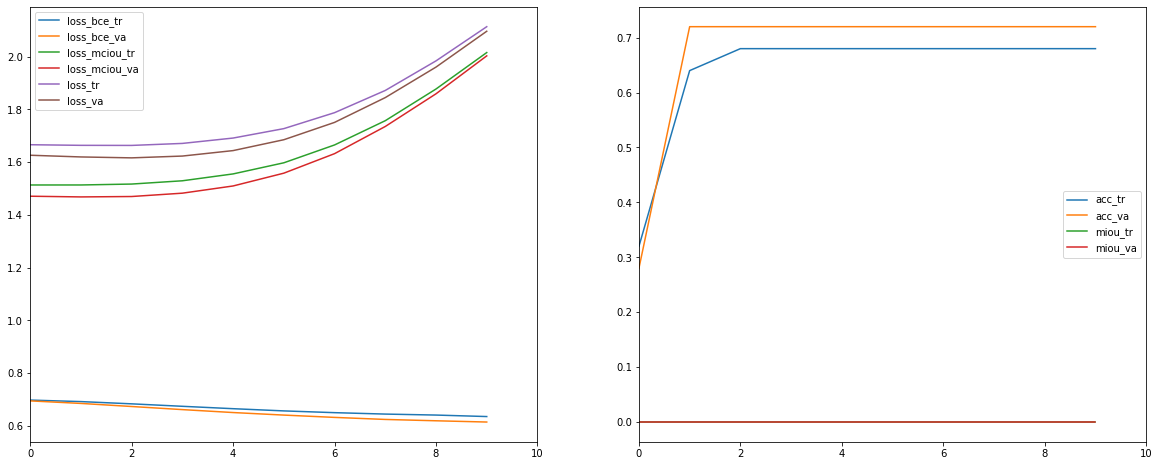

[000] wall:   0:42,  loss: 1.666 / 1.626,  acc.: 0.320 / 0.280,  bce_loss: 0.697 / 0.694,  mciou_loss: 1.513 / 1.471,  miou: 0.000 / 0.000  [000]
[001] wall:   0:41,  loss: 1.664 / 1.620,  acc.: 0.640 / 0.720,  bce_loss: 0.691 / 0.684,  mciou_loss: 1.513 / 1.468,  miou: 0.000 / 0.000  [001]
[002] wall:   0:41,  loss: 1.663 / 1.616,  acc.: 0.680 / 0.720,  bce_loss: 0.683 / 0.673,  mciou_loss: 1.517 / 1.470,  miou: 0.000 / 0.000  [002]
[003] wall:   0:42,  loss: 1.671 / 1.623,  acc.: 0.680 / 0.720,  bce_loss: 0.673 / 0.661,  mciou_loss: 1.529 / 1.482,  miou: 0.000 / 0.000  [003]
[004] wall:   0:41,  loss: 1.691 / 1.644,  acc.: 0.680 / 0.720,  bce_loss: 0.664 / 0.650,  mciou_loss: 1.555 / 1.510,  miou: 0.000 / 0.000  [004]
[005] wall:   0:41,  loss: 1.727 / 1.685,  acc.: 0.680 / 0.720,  bce_loss: 0.656 / 0.640,  mciou_loss: 1.598 / 1.558,  miou: 0.000 / 0.000  [005]
[006] wall:   0:42,  loss: 1.788 / 1.751,  acc.: 0.680 / 0.720,  bce_loss: 0.649 / 0.631,  mciou_loss: 1.665 / 1.632,  miou:

In [34]:
sample_size = 50

trainer.fit(
    X_tr = images.imgs[images.index_tr][:sample_size],
    X_va = images.imgs[images.index_va][:sample_size],
    y_tr = images.meta_ready[images.index_tr][:sample_size],
    y_va = images.meta_ready[images.index_va][:sample_size],
    batch_size = batch_size,
    learning_rate = 1e-3,
    epochs=10,
)